In [3]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 2.0
%config InlineBackend.figure_formats = ['svg']

# Backend specifications

Throughout these experiments we'll use the `ibm_brisbane` processor, focusing on `qubit = 0`.

In [4]:
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

In [5]:
rough_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/GHz, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/GHz, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6778 GHz


In [6]:
reset_circuit = QuantumCircuit(num_qubits, num_cbits)
reset_circuit.measure(qubit, cbit)

reset_circuits = [reset_circuit, reset_circuit]

# Phase 1

## What we're trying to do?

At the end of phase 1, we want to accomplish two things:

1. A high-fidelity $\pi/2$ gate for both (01) and (12) subspace.
2. A high-fidelity $\pi$ gate for both (01) and (12) subspace.

## How we're gonna approach it?

We'll try to explore DRAG techniques, namely $Y$ correction and $Z$ correction.

- By $Y$ correction, I mean adding a scaled quadrature component to the usual Gaussian pulse that we had. The scaling parameter is nominally referred to as the $\beta$ coefficient.
- By $Z$ correction, I mean sending pulses that *do not* necessarily match the (01) and (12) transition frequencies. The detuning is usually on order of MHz.

## What are preventing us from closing phase 1? 

First, the intrinsic charge fluctuations of the 12 subspace. Inherently the charge dispersion of the (12) subspace is on order of MHz, causing dephasing and destroy the relative phase of the eigenstates.

Second, SPAM error. At the moment we're only using a very (I repeat, very) bad discriminator. We perform calibration and tuning using this bad discriminator, which will inevitably cause mislabelling. At some point we would (and we have to) switch to a better scheme of benchmarking. 

## What's the order of calibration here?

I will calibrate the $\pi$ pulse first, because we always need a discriminator. I will calibrate the $\pi/2$ pulse after.

## Part 1 - Fixing the discriminator by calibrating $\pi$ pulse

Ok. First we need a good discriminator.

What will result in a bad discriminator? Two things.

1. The inability to resolve the states
2. The inability to actually prepare the state itself

Now: resolving the states is not my business at the moment. Here I care solely how to prepare the state $|2\rangle$. That means, let $A$ be the confusion matrix, the $A_{22}$ element is thus

\begin{align}
A_{22} = 1 - \Delta_{resolve} - \Delta_{prepare}
\end{align}

I will try to minimize $\Delta_{prepare}$, given the assumption that $\Delta_{resolve}$ is as small as possible! One more thing. This is not an constrained optimization problem. Meaning that $\Delta_{resolve}$ should have **NO** dependence on how $\Delta_{prepare}$ is minimized. Otherwise we'll fuck up ourselves once again. 

### I will assume that $\pi^{(01)}_x$ is good enough.

Now. How do I calibrate $\pi^{(12)}_x$? Let us first perform a Rabi oscillation on (12) subspace with time $\tau_g$ fixed to 32 ns.

In [7]:
amp12_sweep_range = np.linspace(-0.75, 0.75, 100)

rabi12_gate = qiskit.circuit.Gate('Rabi Gate 32ns', weight, [])

rabi32_circs = []

for amp12 in amp12_sweep_range:
    
    with pulse.build(backend=backend) as rabi12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_12_freq, drive_chan)
        pulse.play(pulse.Drag(duration=64, amp=amp12, sigma=16, beta=0), drive_chan)
        
    rabi32_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi32_circ.x(qubit) # prepare state |1>
    rabi32_circ.append(rabi12_gate, [qubit]) # rabi oscillation with incremental amplitude
    rabi32_circ.measure(qubit, cbit)
    rabi32_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)

    rabi32_circs.append(rabi32_circ)

I will now split this into two experiments. One makes use of no discriminator. We'll look at only the oscillation on the IQ plot. One makes use of a previously obtained discriminator. Let us see if the amplitude to be obtained is the same.

In [ ]:
package = []

package = rabi32_circs + reset_circuits

rabi32_job = backend.run(package, meas_level=1, meas_return='avg', shots=2048)
rabi32_job.job_id()

In [8]:
rabi32_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [9]:
rabi32_job = provider.retrieve_job('cr9m7cn3erv00080cx9g')
rabi32_exp = DataAnalysis(experiment=rabi32_job, average=True, shots=2048, qubit=0)
rabi32_exp.retrieve_data(average=True)

In [10]:
rabi32exp_IQdata = np.array(rabi32_exp.IQ_data) 
swept_min = min(amp12_sweep_range)
swept_max = max(amp12_sweep_range)

with open('./calibrator/ape_drag/data/rabi_oscillation'+f'_{rabi32_job.job_id()}'+f'_{swept_min}'+f'_{swept_max}'+'.pkl', 'wb') as f:
    pickle.dump(rabi32exp_IQdata, f)

## Fit extraction

In [14]:
amp_x12 = 0.31520533

# Default discriminator

In [12]:
ground_state_prep = QuantumCircuit(num_qubits, num_cbits)
ground_state_prep.measure(qubit, cbit)

excited_state_prep = QuantumCircuit(num_qubits, num_cbits)
excited_state_prep.x(qubit)
excited_state_prep.measure(qubit, cbit)

x12 = Gate('X12', weight, [])

with pulse.build(backend=backend) as x12sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=amp_x12, sigma=16, beta=0), drive_chan)
        
second_excited_state_prep = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_prep.x(qubit)
second_excited_state_prep.append(x12, [qubit])
second_excited_state_prep.measure(qubit, cbit)
second_excited_state_prep.add_calibration(x12, [qubit], x12sched)

default_discrim_circs = [ground_state_prep, excited_state_prep, second_excited_state_prep]

# Amplitude amplification sequence

In [31]:
with pulse.build(backend=backend) as Rx12_90_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=amp_x12/2, sigma=16, beta=0), drive_chan)
    
with pulse.build(backend=backend) as Rx12_180_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=amp_x12, sigma=16, beta=0), drive_chan)
    
Rx12_90 = qiskit.circuit.Gate('Rx12_90', weight, [])
Rx12_180 = qiskit.circuit.Gate('Rx12_180', weight, [])

RAA_circs_90 = []

for n in [2*i for i in range(20)]:
    amplitude_amplification_circ = QuantumCircuit(num_qubits, num_cbits)
    amplitude_amplification_circ.x(qubit)
    amplitude_amplification_circ.append(Rx12_90, [qubit])
    for i in range(n):
        amplitude_amplification_circ.append(Rx12_90, [qubit])
    amplitude_amplification_circ.measure(qubit, cbit)
    amplitude_amplification_circ.add_calibration(Rx12_90, [qubit], Rx12_90_sched)
    RAA_circs_90.append(amplitude_amplification_circ)

In [32]:
package_RAA_90 = default_discrim_circs + RAA_circs_90

In [33]:
# RAA90_job = backend.run(package_RAA_90, meas_level=1, meas_return='single', shots=2048)
# RAA180_job = backend.run(package_RAA_180, meas_level=1, meas_return='single', shots=2048)

# print(RAA90_job.job_id()), print(RAA180_job.job_id())

In [34]:
provider = IBMProvider('c8732d042e935dde61dc06a7e2121bbd1032d56e20db3075b8a7e2bf86f42779dfe309e656a9b2223292099e127141ac2a05ab1df9157f464043347fb4dd520f')
backend = provider.get_backend('ibm_brisbane')

In [35]:
RAA90_job = provider.retrieve_job('cq7n6y3f1wdg0084agpg')
RAA90_data = DataAnalysis(experiment=RAA90_job, average=False, shots=2048, qubit=0)
RAA90_data.retrieve_data(average=False)
RAA90_data.build_discrim()
RAA90_data.count_pop()
RAA90_data.error_mitiq()

RAA180_job = provider.retrieve_job('cq7f091f1wdg008wk67g')
RAA180_data = DataAnalysis(experiment=RAA180_job, average=False, shots=2048, qubit=0)
RAA180_data.retrieve_data(average=False)
RAA180_data.build_discrim()
RAA180_data.count_pop()
RAA180_data.error_mitiq()

In [36]:
pop2_RAA90_data = RAA90_data.mitiq_data[3:, 2]
pop2_RAA180_data = RAA180_data.mitiq_data[3:, 2]

In [10]:
with open('./phase1/data/pop2_RAA180_data.pkl', 'wb') as f:
    pickle.dump(pop2_RAA180_data, f)

## Roughly calibrating $\pi^{(12)}_x$ pulse

In [13]:
betas_12_rough = np.linspace(-1, 0.5, 150)

rough_Y_correction_gate = qiskit.circuit.Gate('rough_Y_correction_gate', weight, [])

roughYcorrection_circs = []

for reps in [3, 5, 7]:
    
    for beta_sweep in betas_12_rough:
        
        with pulse.build(backend=backend) as rough_Y_correction_sched:
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(rough_12_freq, drive_chan)
            pulse.play(pulse.Drag(duration=64, amp=amp_x12, sigma=16, beta=beta_sweep), drive_chan)
            pulse.play(pulse.Drag(duration=64, amp=-amp_x12, sigma=16, beta=beta_sweep), drive_chan)
            
        roughYcorrection_circ = QuantumCircuit(num_qubits, num_cbits)
        roughYcorrection_circ.x(qubit)
        
        for rep in range(reps):
            roughYcorrection_circ.append(rough_Y_correction_gate, [qubit])
            
        roughYcorrection_circ.measure(qubit, cbit)
        roughYcorrection_circ.add_calibration(rough_Y_correction_gate, [qubit], rough_Y_correction_sched)
        roughYcorrection_circs.append(roughYcorrection_circ)

In [14]:
packageYpi = default_discrim_circs + roughYcorrection_circs + reset_circuits

packageYpi_job = backend.run(packageYpi, meas_level=1, meas_return='single', shots=2048)

print(packageYpi_job.job_id())

/Users/ngdnhtien/Library/Python/3.9/lib/python/site-packages/qiskit_ibm_provider/ibm_backend.py:445: UserWarning: The backend ibm_brisbane is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


cr9rt91adyg0008a979g


In [33]:
packageYpi_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [8]:
packageYpi_job = provider.retrieve_job('cr9rt91adyg0008a979g')
Ypi_data = DataAnalysis(experiment=packageYpi_job, average=False, shots=2048, qubit=0)
Ypi_data.retrieve_data(average=False)
Ypi_data.build_discrim()
Ypi_data.count_pop()
Ypi_data.error_mitiq()

In [9]:
Ypi_data_pop2raw = np.array(Ypi_data.raw_counted)[3:, 2]

with open('./calibrator/ape_drag/data/rough_x12'+f'_{packageYpi_job.job_id()}'+f'_1357_minusPO0_raw.pkl', 'wb') as f:
    pickle.dump(Ypi_data_pop2raw, f)

In [10]:
Ypi_data_pop2 = Ypi_data.mitiq_data[3:, 2]

with open('./calibrator/ape_drag/data/rough_x12'+f'_{packageYpi_job.job_id()}'+f'_1357_minusPO0_mitiq.pkl', 'wb') as f:
    pickle.dump(Ypi_data_pop2, f)

In [12]:
# Fit extraction

beta_x12 = -0.43847568129142345

# New discriminator

In [15]:
with pulse.build(backend=backend) as cal_pi12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=amp_x12, sigma=16, beta=beta_x12), drive_chan)
    
cal_pi12_gate = qiskit.circuit.Gate('cal_pi12_sched', weight, [])

ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(cal_pi12_gate, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(cal_pi12_gate, [qubit], cal_pi12_sched)

new_discrim = [ground_circ, first_excited_state_circ, second_excited_state_circ]

## Part 2. Researching $\pi/2_x^{(12)}$ pulse

Now that I've got myself a good $\pi_x^{(12)}$ pulse. Let's get into the real work.
I'll have to calibrate the $\pi/2_x^{(12)}$ pulse. We'll look into the $Y$ and the $Z$ correction of DRAG. Let us first see if we have phase error in the beginning?

In [14]:
with pulse.build(backend=backend) as rough_hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=x_amp_12/2, sigma=16, beta=-0.5409), drive_chan)
    
rough_hp12_gate = qiskit.circuit.Gate('rough_hp12_sched', weight, [])

with pulse.build(backend=backend) as pseudo_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=x_amp_12/2, sigma=16, beta=0), drive_chan)
    pulse.play(pulse.Drag(duration=64, amp=-x_amp_12/2, sigma=16, beta=0), drive_chan)
    
pseudo_gate = qiskit.circuit.Gate('pseudo_gate', weight, [])

In [15]:
ape_circs = []
reps = [0, 1, 3, 5, 7, 9]

for rep in reps:
    for phase_change in np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100):
        ape_circ = QuantumCircuit(num_qubits, num_cbits)
        ape_circ.x(qubit)
        ape_circ.append(rough_hp12_gate, [qubit])
        for j in range(rep):
            ape_circ.append(pseudo_gate, [qubit])
        
        with pulse.build(backend=backend) as axial_sched:
            drive_chan = pulse.drive_channel(qubit)
            with pulse.phase_offset(phase_change, drive_chan):
                pulse.set_frequency(rough_12_freq, drive_chan)
                pulse.play(pulse.Drag(duration=64, amp=amp12/2, sigma=16, beta=0), drive_chan)
                
        axial_gate = qiskit.circuit.Gate('axial gate', weight, [])
        
        ape_circ.append(axial_gate, [qubit])
        ape_circ.measure(qubit, cbit)
        ape_circ.add_calibration(rough_hp12_gate, [qubit], rough_hp12_sched)
        ape_circ.add_calibration(pseudo_gate, [qubit], pseudo_sched)
        ape_circ.add_calibration(axial_gate, [qubit], axial_sched)
        ape_circs.append(ape_circ)

In [55]:
ape_package = new_discrim + ape_circs

# provider = IBMProvider(token='6b9b4533270a01dad03bb05ddc807f7fd8c138ede7627256571c86abff71fe9d6610c618c7c813526306b06e91a252dc0414322bd2e35b92dd567fa2296c1744')
backend = provider.get_backend('ibm_brisbane')
ape_job = backend.run(ape_package, meas_level=1, meas_return='single', shots=2048)

In [58]:
ape_data = DataAnalysis(experiment=ape_job, average=False, shots=2048, qubit=0)
ape_data.retrieve_data(average=False)
ape_data.build_discrim()
ape_data.count_pop()
ape_data.error_mitiq()

In [59]:
ape_data_pop1 = ape_data.mitiq_data[3:, 1]
ape_data_pop2 = ape_data.mitiq_data[3:, 2]

In [61]:
with open('./phase1/data/ape_data_pop2.pkl', 'wb') as f:
    pickle.dump(ape_data_pop2, f)

# Now we find a Y and a Z solution for the phase-shifted $\pi$. A good Y or Z correction should minimize the population of $|2\rangle$.

In [16]:
reps = [3, 5, 7]

In [17]:
beta_sweep_vals = np.linspace(-2.0, 1.0, 150)

ape_withY_circs = []

for rep in reps:
    for beta_sweep in beta_sweep_vals:
        apeY_circ = QuantumCircuit(num_qubits, num_cbits)
        apeY_circ.x(qubit)
        
        with pulse.build(backend=backend) as rough_hp12_sched:
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(rough_12_freq, drive_chan)
            pulse.play(pulse.Drag(duration=64, amp=amp_x12/2, sigma=16, beta=beta_sweep), drive_chan)

        rough_hp12_gate = qiskit.circuit.Gate('rough_hp12_gate', weight, [])  
        apeY_circ.append(rough_hp12_gate, [qubit])
        
        with pulse.build(backend=backend) as pseudoYcorrect_sched:
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(rough_12_freq, drive_chan)
            pulse.play(pulse.Drag(duration=64, amp=amp_x12/2, sigma=16, beta=beta_sweep), drive_chan)
            pulse.play(pulse.Drag(duration=64, amp=-amp_x12/2, sigma=16, beta=beta_sweep), drive_chan)
        pseudoYcorrect_gate = qiskit.circuit.Gate('pseudo_gate', weight, [])
        
        with pulse.build(backend=backend) as axial_hp_sched:
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(rough_12_freq, drive_chan)
            pulse.play(pulse.Drag(duration=64, amp=-amp_x12/2, sigma=16, beta=beta_sweep), drive_chan)

        axial_hp_gate = qiskit.circuit.Gate('axial_hp_gate', weight, [])
        

        for j in range(rep):
            apeY_circ.append(pseudoYcorrect_gate, [qubit])
            
        apeY_circ.append(axial_hp_gate, [qubit])
        apeY_circ.measure(qubit, cbit)
        apeY_circ.add_calibration(rough_hp12_gate, [qubit], rough_hp12_sched)
        apeY_circ.add_calibration(pseudoYcorrect_gate, [qubit], pseudoYcorrect_sched)
        apeY_circ.add_calibration(axial_hp_gate, [qubit], axial_hp_sched)
        
        ape_withY_circs.append(apeY_circ)

In [18]:
apeY_package = []
apeY_package = new_discrim + ape_withY_circs + reset_circuits

apeY_job = backend.run(apeY_package, meas_level=1, meas_return='single', shots=2048)

apeY_job.job_id()

'craayw30sct0008q4cd0'

In [21]:
apeY_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [22]:
apeY_job = provider.backend.retrieve_job('craayw30sct0008q4cd0')

In [23]:
apeY_data = DataAnalysis(experiment=apeY_job, average=False, shots=2048, qubit=0)
apeY_data.retrieve_data(average=False)
apeY_data.build_discrim()
apeY_data.count_pop()
apeY_data.error_mitiq()

In [24]:
apeY_data_pop1 = apeY_data.mitiq_data[3:-2, 1]
apeY_data_pop2 = apeY_data.mitiq_data[3:-2, 2]

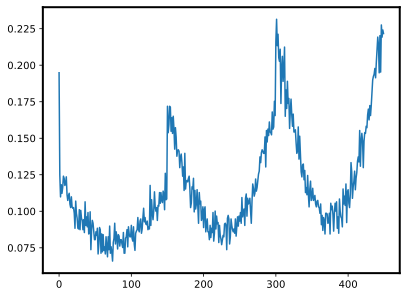

In [25]:
plt.plot(np.array(apeY_data.raw_counted)[3:-2, 2])

In [26]:
apeY_data_pop1_raw = np.array(apeY_data.raw_counted)[3:-2, 1]
apeY_data_pop2_raw = np.array(apeY_data.raw_counted)[3:-2, 2]

In [27]:
with open('./calibrator/ape_drag/data/pop1_ape_drag_sx12'+f'_{apeY_job.job_id()}'+'_0_to_5_357.pkl', 'wb') as f:
    pickle.dump(apeY_data_pop1_raw, f)
    
with open('./calibrator/ape_drag/data/pop2_ape_drag_sx12'+f'_{apeY_job.job_id()}'+'_0_to_5_357.pkl', 'wb') as f:
    pickle.dump(apeY_data_pop2_raw, f)

### Fit extraction

In [28]:
beta_sx12 = -0.49836651995634523

# Now we re-run APE circuit and see what happens.

In [111]:
# b751d05f9c3522f9d46a851e2830dfa0d6087643fcdda1588b781e2f349cbaa8c6d7b1dbec1ec3262857523289bb385ee8ad7b86a83c045ca69aba6b1bc4b3d8

provider = IBMProvider(token='b751d05f9c3522f9d46a851e2830dfa0d6087643fcdda1588b781e2f349cbaa8c6d7b1dbec1ec3262857523289bb385ee8ad7b86a83c045ca69aba6b1bc4b3d8')

In [112]:
ape_withYcorrection_job = provider.backend.retrieve_job('cpv5z5w0f6rg008x7shg') # WITH OPTIMIZED Y CORRECTION # WHO ACCOUNT

ape_withYcorrection_data = DataAnalysis(experiment=ape_withYcorrection_job, average=False, shots=2048, qubit=0)
ape_withYcorrection_data.retrieve_data(average=False)
ape_withYcorrection_data.build_discrim()
ape_withYcorrection_data.count_pop()
ape_withYcorrection_data.error_mitiq()

In [114]:
# Define your colormap
cmap = plt.cm.viridis  # You can choose any other colormap

# Assuming you have some values for gradient_colors that determine the gradient
gradient_colors = np.linspace(0, 1, 5)

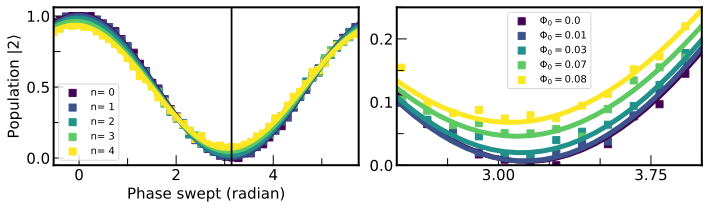

In [117]:
phase_sweep = np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100)

population2_ape_withY = []
ape_params_withY = []
ape_fits_withY = []
initial_phases_withY = []

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

for j in range(5):
    color = cmap(gradient_colors[j])
    population2_ape_withY.append(ape_withYcorrection_data.mitiq_data[(3+j*100):(3+(j+1)*100), 2])
    param, fit = fit_function(phase_sweep, population2_ape_withY[j], 
                                      lambda x, A, B, omega, phi: (A*np.cos(omega*x+phi)+B),
                                      [0.5, 0.5, 1, 0])
    ape_params_withY.append(param)
    ape_fits_withY.append(fit)
    initial_phases_withY.append(param[3])
    ax1.scatter(phase_sweep[::2], population2_ape_withY[j][::2], marker='s', s=50, label=r'n= '+f'{j}', color=color)
    ax2.scatter(phase_sweep[::2], population2_ape_withY[j][::2], marker='s', s=50, label=r'$\Phi_0=$'+f'{round(param[3],2)}', color=color)
    ax1.plot(phase_sweep, ape_fits_withY[j], linewidth=5.0, color=color)
    ax2.plot(phase_sweep, ape_fits_withY[j], linewidth=5.0, color=color)
    

ax1.set_xlim([min(phase_sweep), max(phase_sweep)])
ax2.set_xlim([2.5, 4])
ax2.set_ylim([0, 0.25])
ax1.axvline(3.1415926535897932, color='black', linewidth=1.75)
ax1.set_xlabel('Phase swept (radian)', size=15)
ax1.set_ylabel(r'Population $|2\rangle$', size=15)
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))

ax2.xaxis.set_minor_locator(MultipleLocator(0.25))
ax2.xaxis.set_major_locator(MultipleLocator(0.75))
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_major_locator(MultipleLocator(0.1))

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
    ax.tick_params(axis='both', which='major', length=10, width=1.0)
    ax.tick_params(axis='both', which='minor', length=7, width=1.0)
    ax.legend()
    
fig.tight_layout()
plt.savefig('./phase1/data/logical/step2_calibrating_halfpi_pulse/1_ape_halfpi_Y_correction.png', dpi=300)

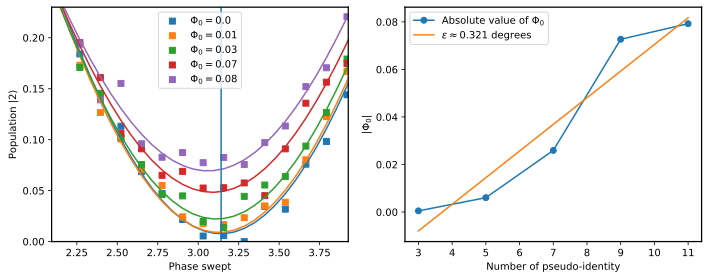

In [129]:
phase_sweep = np.linspace(-np.pi/6, -np.pi/6+2*np.pi, 100)

population2_ape_withY = []
ape_params_withY = []
ape_fits_withY = []
initial_phases_withY = []

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

for j in range(5):
    population2_ape_withY.append(ape_withYcorrection_data.mitiq_data[(3+j*100):(3+(j+1)*100), 2])
    param, fit = fit_function(phase_sweep, population2_ape_withY[j], 
                                      lambda x, A, B, omega, phi: (A*np.cos(omega*x+phi)+B),
                                      [0.5, 0.5, 1, 0])
    ape_params_withY.append(param)
    ape_fits_withY.append(fit)
    initial_phases_withY.append(param[3])
    ax1.scatter(phase_sweep[::2], population2_ape_withY[j][::2], marker='s', label=r'$\Phi_0=$'+f'{round(param[3],2)}')
    ax1.plot(phase_sweep, ape_fits_withY[j])
    
ax1.set_xlim([np.pi/1.5, 5*np.pi/4])
ax1.set_ylim([0, 0.23])
ax1.axvline(3.1415926535897932)
ax1.set_xlabel('Phase swept')
ax1.set_ylabel(r'Population $|2\rangle$')
ax1.legend()

ax2.plot([3, 5, 7, 9, 11], np.abs(initial_phases_withY), label=r'Absolute value of $\Phi_0$', marker='o')
param_linear_Y, fit_linear_Y = fit_function(np.array([3, 5, 7, 9, 11]), np.abs(initial_phases_withY), 
                                      lambda x, epsilon, B: (2*epsilon*x+B),
                                      [1, 0])

ax2.plot([3, 5, 7, 9, 11], fit_linear_Y, label=r'$\epsilon\approx$'+f'{round(param_linear_Y[0]*180/np.pi,3)}'+' degrees')
ax2.set_xlabel('Number of pseudo-identity')
ax2.set_ylabel(r'$|\Phi_0|$')
ax2.legend()
fig.tight_layout()
fig.savefig('./phase1/data/logical/step2_calibrating_halfpi_pulse/1_ape_halfpi_NO_correction.png', dpi=300)

---